In [1]:
import pickle
import os
from easydict import EasyDict
from utils import *
import matplotlib.pyplot as plt
import torch
import numpy as np
import random
# set experiment configs
opt = EasyDict()
# choose a dataset from ["quarter-circle", "half-circle"]
opt.data = "half-circle"
# choose a model from ["CIDA", "PCIDA", "ADDA", "SO", "DANN", "CDANN", "MDD", "CUA"]
opt.model = "CIDA"
# choose run on which device ["cuda", "cpu"]
opt.device = "cpu"

# set random seed
opt.seed = 2333

print("numpy version:", np.__version__)
print("pytorch version:", torch.__version__)

numpy version: 1.18.5
pytorch version: 1.5.0


In [2]:
from imblearn.datasets import make_imbalance

with open('/Users/avin/Desktop/Intrusion Detection/train.pk', 'rb') as f:
    xx, yy = pickle.load(f)
with open('/Users/avin/Desktop/Intrusion Detection/test.pk', 'rb') as f:
    X_test,y_test = pickle.load(f)
X,Y = make_imbalance(xx, yy, sampling_strategy={'normal':2700, 'injection':100, 'impersonation':100, 'flooding':100},random_state=0)
#xx, yy = make_imbalance(X, Y, sampling_strategy={'normal':3000, 'injection':1000, 'impersonation':1000, 'flooding':1000},random_state=0)


In [3]:
import keras
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer

encoder = LabelEncoder()
encoded_y = encoder.fit_transform(Y)

binarizer = LabelBinarizer()
binarized_y = binarizer.fit_transform(encoded_y)
binarized_y.shape

encoded_y_test = encoder.transform(y_test)



In [4]:
for i in range(0,encoded_y.shape[0]):
    if encoded_y[i]==0:
        encoded_y[i]=1
    if encoded_y[i]==2:
        encoded_y[i]=1
for i in range(0,encoded_y.shape[0]):
    if encoded_y[i]==3:
        encoded_y[i]=0
#print(np.count_nonzero(encoded_y == 0))
#print(np.count_nonzero(encoded_y == 1))#outlier

for i in range(0,encoded_y_test.shape[0]):
    if encoded_y_test[i]==0:
        encoded_y_test[i]=1
    if encoded_y_test[i]==2:
        encoded_y_test[i]=1
for i in range(0,encoded_y_test.shape[0]):
    if encoded_y_test[i]==3:
        encoded_y_test[i]=0
#print(np.count_nonzero(encoded_y_test == 0))
#print(np.count_nonzero(encoded_y_test == 1))#outlier


y = keras.utils.to_categorical(encoded_y)
y_test = keras.utils.to_categorical(encoded_y_test)

In [5]:
# training configs
opt.num_epoch = 800
opt.batch_size = 10
opt.lr = 1e-4
opt.lr_T = 1e-4
opt.gamma = 100
opt.beta1 = 0.9
opt.weight_decay = 5e-4
opt.wgan = False
opt.no_bn = True  # do not use batch normalization # True

# model size configs
opt.nx = 90  # dimension of the input data
opt.nh = 800  # dimension of hidden
opt.nc = 2  # number of label class

# dataset configs

opt.dim_domain = 1  # dimension of domain index

# number of domains in the dataset
if opt.data == "quarter-circle":
    opt.num_domain = 15
    opt.num_source = 6
    opt.normalize_domain = False
elif opt.data == "half-circle":
    opt.num_domain = 30
    opt.num_source = 6
    opt.normalize_domain = False    
elif opt.data == "sine":
    opt.num_domain = 12
    opt.num_source = 5
    opt.normalize_domain = True  # normalize data per domain
else:
    assert False, "Can't find data"
opt.num_target = opt.num_domain - opt.num_source

# model specific configs

opt.cond_disc = False  # use conditional discriminator
opt.continual_da = False  # use continual domain adaptation

opt.lambda_gan = 2.0

if opt.model == 'CIDA':
    opt.lambda_gan = 0.4

elif opt.model == 'PCIDA':
    opt.lambda_gan = 1.0
    opt.nmix = 1  # number of mix guassian for the discriminator prediction
    # opt.no_bn = False

elif opt.model == "MDD":
    opt.lambda_src = 1.0
    opt.lambda_tgt = 1.0
    opt.lambda_gan = 2.0
    opt.num_epoch = 160  # early stop (optional) 

elif opt.model == 'CDANN':
    opt.cond_disc = True

elif opt.model == 'CUA':
    opt.continual_da = True
    opt.num_da_step = 5  # number of steps of domain adaptation
    opt.num_epoch_pre = 10  # number of epochs of pretraining in source domain
    opt.num_epoch_sub = 50  # number of epochs of adapting to a new sub target domain
    opt.lr_decay_period = 500
    opt.lambda_gan = 1.0
    opt.lambda_rpy = 0.3

opt.exp = opt.data + '_' + opt.model
opt.outf = './dump/' + opt.exp
os.system('mkdir -p ' + opt.outf)

opt.use_resample = False

(3000, 90)


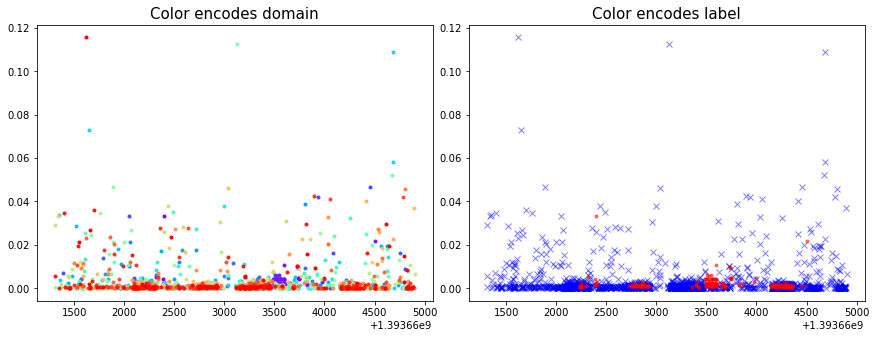

SeqDataset Size 100 Sub Size [100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]


<ipython-input-6-f5c614291ba4>:47: RuntimeWarning: invalid value encountered in true_divide
  data = (data - data_mean) / data_std  # normalize the raw data


In [6]:

def split_dataframe(df, chunk_size = 1000): 
    chunks = list()
    num_chunks = len(df) // chunk_size + 1
    for i in range(num_chunks):
        chunks.append(df[i*chunk_size:(i+1)*chunk_size])
    return chunks

def select_columns(data_frame, column_names):
    new_frame = data_frame.loc[:, column_names]
    return new_frame
from dataset import *
from plot import plot_dataset
import pandas as pd

# load raw data

#print(f"Data: {data_pkl['data'].shape}\nLabel: {data_pkl['label'].shape}")


data_pkl = read_pickle(f'./data/{opt.data}.pkl')
selected_columns = ['frame.time_epoch','frame.time_delta', 'frame.time_delta_displayed', 'frame.time_relative', 'frame.len', 'frame.cap_len', 'radiotap.length', 'radiotap.present.tsft', 'radiotap.present.flags', 'radiotap.present.channel', 'radiotap.present.dbm_antsignal', 'radiotap.present.antenna', 'radiotap.present.rxflags', 'radiotap.mactime', 'radiotap.flags.fcs', 'radiotap.datarate', 'radiotap.channel.freq', 'radiotap.channel.type.cck', 'radiotap.channel.type.ofdm','radiotap.channel.type.2ghz', 'radiotap.dbm_antsignal','radiotap.antenna', 'wlan.fc.type_subtype', 'wlan.fc.type', 'wlan.fc.subtype', 'wlan.fc.ds', 'wlan.fc.frag', 'wlan.fc.retry', 'wlan.fc.pwrmgt', 'wlan.fc.moredata', 'wlan.fc.protected', 'wlan.duration', 'wlan.ra', 'wlan.da', 'wlan.ta', 'wlan.sa', 'wlan.bssid', 'wlan.frag', 'wlan.seq', 'wlan.bar.type', 'wlan.ba.control.ackpolicy', 'wlan.ba.control.cbitmap', 'wlan.ba.bm', 'wlan.fcs_good', 'wlan_mgt.fixed.capabilities.ess', 'wlan_mgt.fixed.capabilities.ibss', 'wlan_mgt.fixed.capabilities.cfpoll.ap', 'wlan_mgt.fixed.capabilities.privacy', 'wlan_mgt.fixed.capabilities.preamble', 'wlan_mgt.fixed.capabilities.pbcc', 'wlan_mgt.fixed.capabilities.agility', 'wlan_mgt.fixed.capabilities.spec_man', 'wlan_mgt.fixed.capabilities.short_slot_time', 'wlan_mgt.fixed.capabilities.apsd', 'wlan_mgt.fixed.capabilities.radio_measurement', 'wlan_mgt.fixed.capabilities.dsss_ofdm', 'wlan_mgt.fixed.capabilities.del_blk_ack', 'wlan_mgt.fixed.capabilities.imm_blk_ack', 'wlan_mgt.fixed.listen_ival', 'wlan_mgt.fixed.current_ap', 'wlan_mgt.fixed.status_code', 'wlan_mgt.fixed.timestamp', 'wlan_mgt.fixed.beacon', 'wlan_mgt.fixed.aid', 'wlan_mgt.fixed.reason_code', 'wlan_mgt.fixed.auth.alg', 'wlan_mgt.fixed.auth_seq', 'wlan_mgt.fixed.sequence', 'wlan_mgt.tagged.all', 'wlan_mgt.ds.current_channel', 'wlan_mgt.tim.dtim_count', 'wlan_mgt.tim.dtim_period', 'wlan_mgt.tim.bmapctl.multicast', 'wlan_mgt.country_info.environment', 'wlan_mgt.rsn.version', 'wlan_mgt.rsn.gcs.type', 'wlan_mgt.rsn.pcs.count', 'wlan_mgt.rsn.akms.count', 'wlan_mgt.rsn.akms.type', 'wlan_mgt.rsn.capabilities.preauth', 'wlan_mgt.rsn.capabilities.ptksa_replay_counter', 'wlan_mgt.tcprep.trsmt_pow', 'wlan.wep.iv', 'wlan.wep.key', 'wlan.wep.icv','wlan.tkip.extiv', 'wlan.ccmp.extiv', 'wlan.qos.tid', 'wlan.qos.priority', 'data.len']
data_df = select_columns(X, selected_columns)
print(data_df.shape)
data= data_df.to_numpy()

label=encoded_y

domain= data_pkl['domain']

#create dictionary
awid={
    'data': data,
    'label': label,
    'domain': domain
}    

#save to pickle file
with open('awid.pkl', 'wb') as f:
    pickle.dump(awid, f)

#visualize raw data
plot_dataset(awid)

#datasets=split_dataframe(ff, 1000)
data_mean = data.mean(0)
data_std = data.std(0)
data = (data - data_mean) / data_std  # normalize the raw data
datasets = [ToyDataset(awid, i, opt) for i in range(opt.num_domain)]  # sub dataset for each domain
dataset = SeqToyDataset(datasets, size=len(datasets[0]))  # mix sub dataset to a large one
dataloader = DataLoader(
    dataset=dataset,
    shuffle=True,
    batch_size=opt.batch_size
)

In [7]:
#print(dataloader.dataset.datasets[1].data)
print(datasets[1].data.shape)
print(type(datasets))

(100, 90)
<class 'list'>


In [8]:

from model import get_model

# set random seed (for reproducibility)
np.random.seed(opt.seed)
random.seed(opt.seed)
torch.manual_seed(opt.seed)

# build the model
modelClass = get_model(opt.model)
model = modelClass(opt)
model.to(opt.device)
print(model)

if opt.normalize_domain:
    model.set_data_stats(
        dm=[d.data_m for d in datasets],
        ds=[d.data_s for d in datasets],
    )
    
# train the model
if not opt.continual_da:
    # one-step adaptation
    for epoch in range(opt.num_epoch):
        model.learn(epoch, dataloader)
        if (epoch + 1) % 100 == 0 or (epoch + 1) == opt.num_epoch:
            model.save()
            # model.visualize_D()
            # model.visualize_F()
            # model.visualize_E()
        if (epoch + 1) % 50 == 0:    
            model.test(epoch, dataloader)
else:
    # pretrain on source
    print('===> pretrain the classifer')
    model.prepare_trainer(init=True)
    for epoch in range(opt.num_epoch_pre):
        model.learn(epoch, dataloader, init=True)
        if (epoch + 1) % 10 == 0:
            model.save()
            model.visualize_F()
            model.test(epoch, dataloader)
    # step-by-step domain adapt
    ds_size = len(datasets[0])
    replay_datasets = [datasets[i] for i in range(opt.num_source)]
    print('===> start continual DA')
    model.prepare_trainer(init=False)
    for phase in range(opt.num_source, opt.num_domain):
        continual_dataset = SeqToyDataset(replay_datasets, size=ds_size)
        continual_dataloader = DataLoader(
            dataset=continual_dataset,
            shuffle=True,
            batch_size=opt.batch_size,
            num_workers=4,
        )
        model.set_phase(phase)
        for epoch in range(opt.num_epoch_sub):
            model.learn(epoch, (dataloader, continual_dataloader), init=False)
        # model.visualize_F(phase)
        model.save()
        model.test(epoch, dataloader)
        replay_data, replay_label = model.gen_replay_dataset(dataloader)
        replay_datasets.append(ReplayDataset(replay_data, replay_label, opt))

===> Discrinimator Output Activation: identity
CIDA(
  (netE): FeatureNet(
    (fc1): Linear(in_features=90, out_features=800, bias=True)
    (fc2): Linear(in_features=1600, out_features=1600, bias=True)
    (fc3): Linear(in_features=1600, out_features=1600, bias=True)
    (fc4): Linear(in_features=1600, out_features=1600, bias=True)
    (fc_final): Linear(in_features=1600, out_features=800, bias=True)
    (fc1_var): Linear(in_features=1, out_features=800, bias=True)
    (fc2_var): Linear(in_features=800, out_features=800, bias=True)
  )
  (netF): PredNet(
    (fc3): Linear(in_features=800, out_features=800, bias=True)
    (bn3): Identity()
    (fc4): Linear(in_features=800, out_features=800, bias=True)
    (bn4): Identity()
    (fc_final): Linear(in_features=800, out_features=2, bias=True)
  )
  (netD): DiscNet(
    (fc3): Linear(in_features=800, out_features=800, bias=True)
    (bn3): Identity()
    (fc4): Linear(in_features=800, out_features=800, bias=True)
    (bn4): Identity()
   

[Train][209] Loss: D 30150277.400 E_gan -27437783.000 E_pred 291235276.800 E_pseudo 105542301.600
[Train][209] Accuracy: total average 83.7, in each domain [ 76.  61. 100.  85.  82.  81.  82.  90.  81.  92.  87.  82.  92.  84.
  78.  84.  81.  79.  84.  85.  81.  87.  85.  83.  87.  88.  89.  82.
  84.  78.]
[Train][219] Loss: D 192128787.200 E_gan -157543114.600 E_pred 294508718.400 E_pseudo 83730932.850
[Train][219] Accuracy: total average 79.9, in each domain [ 81.  72. 100.  81.  77.  78.  84.  83.  76.  82.  83.  79.  81.  81.
  74.  72.  80.  79.  82.  82.  77.  86.  79.  80.  79.  74.  83.  72.
  79.  80.]
[Train][229] Loss: D 378951335.800 E_gan -440013967.200 E_pred 108508358.000 E_pseudo 35585104.375
[Train][229] Accuracy: total average 83.7, in each domain [ 78.  79. 100.  84.  87.  84.  87.  86.  88.  87.  86.  84.  82.  82.
  82.  83.  79.  78.  82.  85.  83.  87.  84.  81.  81.  82.  85.  86.
  82.  78.]
[Train][239] Loss: D 75070399.500 E_gan -70559387.400 E_pred 2989027

[Train][449] Loss: D 19299625907.200 E_gan -16866981286.400 E_pred 41859526.650 E_pseudo 14969825.500
[Train][449] Accuracy: total average 84.0, in each domain [ 79.  84. 100.  83.  90.  84.  85.  86.  86.  87.  88.  85.  84.  89.
  76.  81.  80.  81.  87.  86.  78.  88.  85.  79.  80.  81.  86.  84.
  77.  80.]
[Test][449] Accuracy: total average 74.8, in each domain [100. 100. 100.  73.  78.  72.  75.  74.  71.  73.  78.  67.  69.  71.
  66.  71.  70.  70.  75.  73.  68.  77.  72.  72.  75.  71.  75.  71.
  71.  66.]
[Train][459] Loss: D 11964292224.000 E_gan -9942002278.400 E_pred 38251707.800 E_pseudo 20291310.550
[Train][459] Accuracy: total average 81.4, in each domain [ 71.  79. 100.  82.  81.  86.  81.  79.  80.  83.  84.  78.  82.  81.
  81.  79.  77.  78.  87.  82.  79.  83.  85.  86.  78.  83.  82.  79.
  76.  79.]
[Train][469] Loss: D 15435813632.000 E_gan -14781341529.600 E_pred 173618218.022 E_pseudo 3897369.344
[Train][469] Accuracy: total average 86.9, in each domain [ 

[Train][679] Loss: D 1199709347.200 E_gan -1183535798.400 E_pred 1685133.256 E_pseudo 787214.448
[Train][679] Accuracy: total average 88.2, in each domain [ 86.  96. 100.  86.  88.  84.  89.  85.  91.  90.  91.  92.  86.  92.
  83.  88.  82.  84.  88.  90.  86.  91.  91.  86.  87.  90.  91.  84.
  83.  85.]
[Train][689] Loss: D 997661360.000 E_gan -695053686.400 E_pred 1792129.927 E_pseudo 398420.813
[Train][689] Accuracy: total average 84.3, in each domain [ 85.  98. 100.  83.  88.  85.  88.  84.  85.  86.  87.  84.  81.  85.
  76.  79.  78.  83.  87.  86.  81.  86.  86.  78.  80.  81.  85.  83.
  79.  81.]
[Train][699] Loss: D 1937429132.800 E_gan -1559433811.200 E_pred 2823035.538 E_pseudo 1307694.838
[Train][699] Accuracy: total average 86.3, in each domain [ 93.  81. 100.  85.  91.  86.  89.  87.  86.  90.  91.  90.  88.  87.
  77.  87.  82.  82.  87.  86.  87.  87.  88.  82.  82.  82.  85.  85.
  83.  83.]
[Test][699] Accuracy: total average 91.6, in each domain [ 87.  98. 100.  